In [1]:
# Import the neccessary modules for data manipulation and visual representation
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as matplot
import seaborn as sns
%matplotlib inline

import scipy.stats as stats

from sklearn.preprocessing import LabelEncoder
from sklearn.cross_validation import StratifiedKFold
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score, precision_recall_curve

from catboost import CatBoostClassifier

import os
print(os.listdir("../input"))

/opt/conda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


['train.csv', 'sample_submission.csv', 'test.csv']


### Data import

In [2]:
# Read the csv files and store the datasets into train and test
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')
submission = pd.read_csv('../input/sample_submission.csv')

In [3]:
y = train.is_promoted

In [4]:
print("Train shape: {}\n Test shape: {}\n".format(train.shape, test.shape))

Train shape: (54808, 14)
 Test shape: (23490, 13)



In [5]:
# Check how many people are promoted (whether we have an imbalanced dataset)
promo_rate = train.is_promoted.value_counts() / len(train)
promo_rate

0    0.91483
1    0.08517
Name: is_promoted, dtype: float64

In [6]:
# Concatenate train and test
df = pd.concat([train.drop(['employee_id', 'is_promoted'], axis=1), 
                test.drop('employee_id', axis=1)], axis=0)
ntrain = train.shape[0]
ntest = test.shape[0]

In [7]:
df.shape

(78298, 12)

In [8]:
df.head()

,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score
0,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49
1,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60
2,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50
3,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50
4,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73


In [9]:
# Check to see if there are any missing values in data set
df.isnull().any()

department              False
region                  False
education                True
gender                  False
recruitment_channel     False
no_of_trainings         False
age                     False
previous_year_rating     True
length_of_service       False
KPIs_met >80%           False
awards_won?             False
avg_training_score      False
dtype: bool

### Feature Engineering

In [10]:
df['dept_region'] = df['department'] + df['region']

df['work_fraction'] = df['length_of_service'] / df['age']
train['work_fraction'] = train['length_of_service'] / train['age']

df['department_rating_mean'] = df.groupby('department')['previous_year_rating'].transform('mean')
df['department_score_mean'] = df.groupby('department')['avg_training_score'].transform('mean')

df['department_rating_mean'] = df['previous_year_rating']/df['department_rating_mean'] 
df['department_score_mean'] = df['avg_training_score']/df['department_score_mean'] 

df['dept_region_rating_mean'] = df.groupby('dept_region')['previous_year_rating'].transform('mean')
df['dept_region_score_mean'] = df.groupby('dept_region')['avg_training_score'].transform('mean')

df['dept_region_rating_mean'] = df['previous_year_rating']/df['dept_region_rating_mean'] 
df['dept_region_score_mean'] = df['avg_training_score']/df['dept_region_score_mean'] 

### Replace NA values with `'NA'` for `education` and `0` for `previous_year_rating` 

In [11]:
df.education.fillna('NA', inplace=True)
df.previous_year_rating.fillna(0, inplace=True)

In [12]:
df.education.value_counts()

Bachelor's          52247
Master's & above    21429
NA                   3443
Below Secondary      1179
Name: education, dtype: int64

In [13]:
# Check the type of our features. 
df.dtypes

department                  object
region                      object
education                   object
gender                      object
recruitment_channel         object
no_of_trainings              int64
age                          int64
previous_year_rating       float64
length_of_service            int64
KPIs_met >80%                int64
awards_won?                  int64
avg_training_score           int64
dept_region                 object
work_fraction              float64
department_rating_mean     float64
department_score_mean      float64
dept_region_rating_mean    float64
dept_region_score_mean     float64
dtype: object

In [14]:
cats = [col for col in df.columns if not pd.api.types.is_numeric_dtype(df[col].dtype)]

In [15]:
cats = cats + ['KPIs_met >80%','awards_won?', 'previous_year_rating']

In [16]:
cats

['department',
 'region',
 'education',
 'gender',
 'recruitment_channel',
 'dept_region',
 'KPIs_met >80%',
 'awards_won?',
 'previous_year_rating']

### Basic EDA

In [17]:
# Display the statistical overview of the employees
df.describe().drop('count', axis=0).T

,mean,std,min,25%,50%,75%,max
no_of_trainings,1.253378,0.606766,1.000000,1.000000,1.000000,1.000000,10.000000
age,34.797619,7.665928,20.000000,29.000000,33.000000,39.000000,60.000000
previous_year_rating,3.079593,1.499173,0.000000,2.000000,3.000000,4.000000,5.000000
length_of_service,5.848974,4.248070,1.000000,3.000000,5.000000,7.000000,37.000000
KPIs_met >80%,0.354032,0.478222,0.000000,0.000000,0.000000,1.000000,1.000000
awards_won?,0.023053,0.150073,0.000000,0.000000,0.000000,0.000000,1.000000
avg_training_score,63.349664,13.383664,39.000000,51.000000,60.000000,76.000000,99.000000
work_fraction,0.159293,0.089331,0.023256,0.086957,0.145833,0.216216,0.622642
department_rating_mean,1.000000,0.377830,0.274759,0.824277,0.975695,1.300927,1.626159
department_score_mean,1.000000,0.081644,0.776761,0.962678,0.995848,1.026174,1.971778


In [18]:
# Overview of summary (promoted VS not promoted)
promo_summary = train.drop('employee_id', axis=1).groupby('is_promoted')
promo_summary.mean().T

is_promoted,0,1
no_of_trainings,1.257639,1.203299
age,34.844037,34.372965
previous_year_rating,3.267911,3.986140
length_of_service,5.879398,5.716367
KPIs_met >80%,0.319685,0.698800
awards_won?,0.014180,0.119751
avg_training_score,62.647686,71.325193
work_fraction,0.159749,0.158341


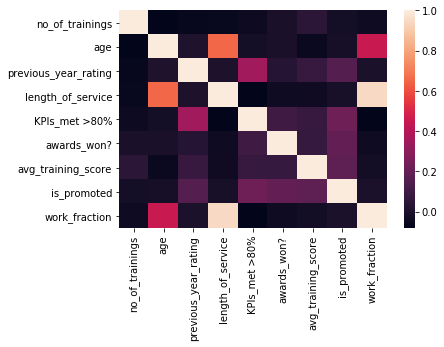

In [19]:
#Correlation Matrix
corr = train.drop('employee_id', axis=1).corr()
corr = (corr)
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values);

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


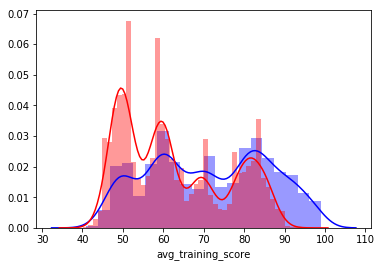

In [20]:
sns.distplot(train.avg_training_score[train.is_promoted==1], color='blue');
sns.distplot(train.avg_training_score[train.is_promoted==0], color='red');

In [21]:
# Try additionally binning the avg_training_score
avg_score = pd.cut(df.avg_training_score, 
                   [0, 45, 55, 65, 75, 85, 95], 
                   labels=False, 
                   retbins=False, 
                   right=False)
df['avg_training_score_bin'] = avg_score

In [22]:
cats = cats + ['avg_training_score_bin']

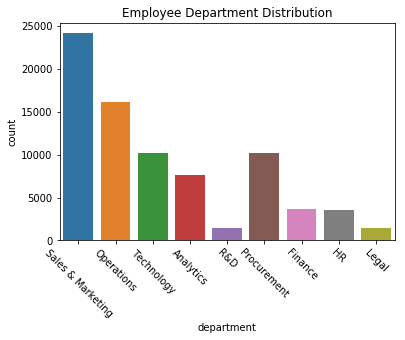

In [23]:
# Count Plot (a.k.a. Bar Plot)
sns.countplot(x='department', data=df).set_title('Employee Department Distribution');
plt.xticks(rotation=-45);

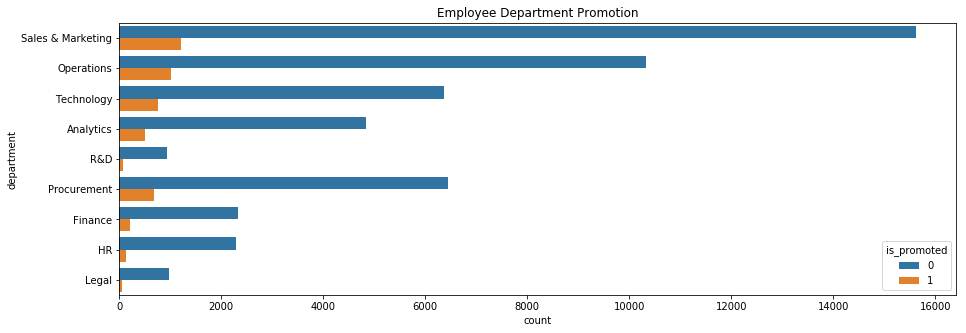

In [24]:
f, ax = plt.subplots(figsize=(15, 5))
sns.countplot(y="department", hue='is_promoted', data=train).set_title('Employee Department Promotion');

### Prepare the categorical variables

In [25]:
le = LabelEncoder()
for c in cats:
    df[c] = le.fit_transform(df[c])

In [26]:
cats_idx = [df.columns.get_loc(c) for c in cats]

In [27]:
cats_idx

[0, 1, 2, 3, 4, 12, 9, 10, 7, 18]

### Model training

In [28]:
clf=CatBoostClassifier(iterations=800,
                       #depth = 3,
                       #bagging_temperature = 1,
                       cat_features=cats_idx, 
                       use_best_model=True,
                       silent = True,
                       random_state = 23,
                       eval_metric = 'F1',
                       #l2_leaf_reg = 10,
                       od_type = 'Iter',
                       od_wait = 200,
                       loss_function='CrossEntropy')

In [29]:
st_train = df.iloc[:ntrain, :].values
st_test = df.iloc[ntrain:, :].values

In [30]:
n_folds = 10

In [31]:
def scoring(y_true, y_hat):
    
    ths = []
    f1scores = []
    for th in np.arange(0.0, 1.0, 0.005):
        y_hat_bin = y_hat>=th
        f1scores.append(f1_score(y_true, y_hat_bin))
        ths.append(th)
    
    return np.max(f1scores), ths[np.argmax(f1scores)]

In [32]:
def cat_train(random_state):
    cv = StratifiedKFold(y, n_folds=n_folds, shuffle=True, random_state=random_state)
    X_proba = np.zeros(ntrain)
    X_preds = np.zeros(ntrain)
    preds = np.zeros(ntest)
    for i, (tr, ts) in enumerate(cv):
        mod = clf.fit(st_train[tr], y[tr],
                     eval_set=(st_train[ts], y[ts]))
        X_proba[ts] = mod.predict_proba(st_train[ts])[:,1]
        score = roc_auc_score(y[ts], X_proba[ts])
        
        score_valid, best_th = scoring(y[ts], X_proba[ts]) 
        X_preds[ts] = (X_proba[ts]>=best_th) * 1
        f1 = f1_score(y[ts], X_preds[ts])
        
        pred = mod.predict_proba(st_test)[:,1]
        preds += (pred>=best_th) * 1
                              
        print("fold {}, ROC AUC: {:.3f}, F1 Score: {:.5f}".format(i,score,f1))
              
    score = roc_auc_score(y, X_proba)
    f1 = f1_score(y, X_preds)
    print("Full ROC AUC: {:.3f}, F1 Score: {:.5f}".format(score, f1))
    preds = (preds >= 5) * 1
    return X_proba, X_preds, preds, score, f1

In [33]:
preds_folds = []
X_preds_folds = []
X_proba_folds = []
auc_folds = []
f1_folds = []

for i in range(10):
    X_proba, X_preds, preds, score, f1 = cat_train(40+i)
    auc_folds.append(score)
    f1_folds.append(f1)
    preds_folds.append(preds)
    X_preds_folds.append(X_preds)
    X_proba_folds.append(X_proba)

Learning rate set to 0.129271
fold 0, ROC AUC: 0.918, F1 Score: 0.53001
Learning rate set to 0.129271
fold 1, ROC AUC: 0.904, F1 Score: 0.52562
Learning rate set to 0.129271
fold 2, ROC AUC: 0.907, F1 Score: 0.51495
Learning rate set to 0.129271
fold 3, ROC AUC: 0.914, F1 Score: 0.51902
Learning rate set to 0.129271
fold 4, ROC AUC: 0.921, F1 Score: 0.56225
Learning rate set to 0.129271
fold 5, ROC AUC: 0.915, F1 Score: 0.52851
Learning rate set to 0.129271
fold 6, ROC AUC: 0.911, F1 Score: 0.51829
Learning rate set to 0.129271
fold 7, ROC AUC: 0.911, F1 Score: 0.53259
Learning rate set to 0.129272
fold 8, ROC AUC: 0.914, F1 Score: 0.56913
Learning rate set to 0.129272
fold 9, ROC AUC: 0.909, F1 Score: 0.53680
Full ROC AUC: 0.912, F1 Score: 0.53347
Learning rate set to 0.129271
fold 0, ROC AUC: 0.923, F1 Score: 0.53256
Learning rate set to 0.129271
fold 1, ROC AUC: 0.911, F1 Score: 0.53590
Learning rate set to 0.129271
fold 2, ROC AUC: 0.909, F1 Score: 0.53804
Learning rate set to 0.12

### Model evaluation

In [34]:
X_proba = np.mean(X_proba_folds, axis=0)

In [35]:
score = roc_auc_score(y, X_proba)
f1 = f1_score(y, [round(value) for value in X_proba])
print("Total ROC AUC: {:.3f}, F1 Score: {:.5f}".format(score, f1))

Total ROC AUC: 0.914, F1 Score: 0.51327


In [36]:
X_proba = X_proba_folds[0]
for i in range(1, 9):
    X_proba *= X_proba_folds[i]
X_proba = np.power(X_proba, 1/10)

In [37]:
score = roc_auc_score(y, X_proba)
f1 = f1_score(y, [round(value) for value in X_proba])
print("Total ROC AUC: {:.3f}, F1 Score: {:.5f}".format(score, f1))

Total ROC AUC: 0.914, F1 Score: 0.51337


In [38]:
X_preds = np.zeros_like(y)

for i in range(10):
    score_valid, best_th = scoring(y, X_proba_folds[i]) 
    X_preds += (X_proba_folds[i]>=best_th) * 1

X_preds = (X_preds >= 5) * 1
f1 = f1_score(y, X_preds)
print("F1 Score: {:.5f}".format(f1))

F1 Score: 0.53048


In [39]:
X_preds = (pd.DataFrame(X_preds_folds).T.apply(sum, axis=1) >= 5) * 1
f1 = f1_score(y, X_preds)
print("F1 Score: {:.5f}".format(f1))

F1 Score: 0.53827


In [40]:
preds = (pd.DataFrame(preds_folds).T.apply(sum, axis=1) >= 5) * 1

In [41]:
submission.is_promoted = preds
submission.to_csv('submission.csv', index=False)